# ASDI Demo Cases - Using TAP and a MAST API

This notebook shows how to use a TAP service to download pristine synthetic data from the MAST archive, and a second service that performs instrument simulations on that data server-side.  

For more information, see the ASDI Prototype documentation here: https://archive.stsci.edu/access-mast-data/asdi/asdi-prototype-demo

***
## Imports

In [1]:
# Use the astroquery TapPlus library as our client to the data service.
from astroquery.utils.tap.core import TapPlus

# For handling ordinary astropy Tables in responses
from astropy.table import Table

# For displaying and manipulating some types of results
import astropy
import time
import numpy as np
import astropy.io.fits as fits
import requests
import os
from zipfile import ZipFile 

#plotting routines
import matplotlib
from matplotlib import pyplot

## TAP Service Introduction

Table Access Protocol (TAP) services allow more direct and flexible access to astronomical data than the simpler types of IVOA standard data services. Queries are built with the SQL-like Astronomical Data Query Language (ADQL), and can include geographic / spatial queries as well as filtering on other characteristics of the data. This also allows the user fine-grained control over the returned columns, unlike the fixed set of coumns returned from cone, image, and spectral services.

## Service Specific Configuration

Every TAP service has a "Base URL" plus associated endpoints for synchronous and asynchronous queries, as well as status and capability information, and sometimes service-provided sample queries. The endpoints are predefined in the TAP standard, so clients can infer them using the base. We therefore only have to provide astroquery that base.

In [2]:
TAP_URL = "http://vaotest.stsci.edu/ASDI/tapservice.aspx"
TAP_service = TapPlus(url=TAP_URL)

Created TAP+ (v1.0.1) - Connection:
	Host: vaotest.stsci.edu
	Use HTTPS: False
	Port: 80
	SSL Port: 443


### Browsing the Schema

TAP gives us access to descriptive metadata for this catalog. We can use this to narrow searches and filter our results. For the current catalog, there is only one table, with columns for the project name, nullable fields relevant to various projects, and a public path for downloading associated files.

In [17]:
table_descriptions = TAP_service.load_tables()
print('\n')
for table in table_descriptions:
    if(not table.name.startswith('tap_schema')):
        print('TAP table: ' + table.name)
        print(table.description)
        print('\n')
        for i, column in enumerate(table.columns):
            print(column.name)
            print(column.description,'\n')

Retrieving tables...
Parsing tables...
Done.


TAP table: dbo.ASDISpectra1dCGM
A view created by joining the HLSPASDISpectra1dCGMProduct table (file-level information) with HLSPASDISpectra1dCGMLine table (spectral line-level information)


lineName
Name of the transition associated with this spectral feature. Available entries: 'C IV 1548', 'H I 1216', 'H I 919', 'O VI 1032', 'Si II 1260', 'Si IV 1394' 

restWave
Rest-frame wavelength 

physIonDensity
Ionic column-density-weighted density 

totalColumn
Total column number density of this ion. Units are log cm^-2. 

physIonTemperature
Ionic column-density-weighted temperature 

physIonMetallicity
Ionic column-density-weighted metallicity, in units of solar metallicity 

projectName
Name of the simulation suite. Available entries: 'foggie' 

physicsName
Name of the physics set assumed for these simulations. Available entries: 'nref11n-nref10f' 

seriesName
Name of the simulation series (for example, name of the halo evolved over time). A

***
# ASDI CGM Use Case 1
Search for simulated CGM sightlines at 1.8 <= z <= 2.5 with O VI and Si II absorption. To compare with our own data, we want only sightlines with OVI column density > 10^12.75 cm-2. First we search for FOGGIE simulation lines of sight. We remotely search a catalog with redshifts and line column densities, impact parameters, galaxy stellar masses, galaxy star formation rates, and other quantities. 

In this example, we download the entire catalog for the resulting sightlines.  However, we can also filter server-side by replacing "SELECT \*" with, e.g., "SELECT lineName, extNum, redshift, totalColumn, impact, mstar, sfr, publicPath"

In [36]:
# Launch TAP query
job = TAP_service.launch_job("""
            SELECT *
            FROM dbo.ASDISpectra1DCGM 
            WHERE projectName = 'foggie' AND
            (lineName = 'O VI 1032' OR lineName = 'Si II 1260') AND
            (redshift >= 1.8 and redshift <= 2.5) AND
            totalColumn >= 12.75
            """)
# Obtain results
foggie_results = job.get_results()

# Print available columns in resulting catalog
for c in foggie_results.columns: print(c)

lineName
restWave
physIonDensity
totalColumn
physIonTemperature
physIonMetallicity
projectName
physicsName
seriesName
galaxyName
redshift
mstar
sfr
impact
direction
pos1
pos2
numLines
creationDate
publicPath
extName
extNum


In [37]:
# Display example entires in resulting catalog
foggie_results[['lineName','redshift','totalColumn','impact','publicPath']][0:10]

lineName,redshift,totalColumn,impact,publicPath
,dimensionless,log cm^-2,physical kpc,
bytes36,float64,float32,object,bytes250
O VI 1032,2.4999995,13.34705,40.175870626938568364,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0018/axx/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0018-axx-dy005.6-dz066.6_v1_pristine-los.fits
O VI 1032,2.4999995,13.37358,39.19119058176030279,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0018/axx/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0018-axx-dy005.7-dz065.1_v1_pristine-los.fits
O VI 1032,2.4999995,13.08275,32.25114087847141775,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0018/axx/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0018-axx-dy005.9-dz033.6_v1_pristine-los.fits
O VI 1032,2.4999995,13.03269,43.044143055335069903,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0018/axx/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0018-axx-dy006.4-dz071.8_v1_pristine-los.fits
O VI 1032,2.4999995,12.75337,47.242586779792787866,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0018/axx/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0018-axx-dy006.6-dz077.7_v1_pristine-los.fits
O VI 1032,2.4999995,13.37122,32.295115754447479617,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0018/axx/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0018-axx-dy006.9-dz030.3_v1_pristine-los.fits
O VI 1032,2.4999995,14.23466,29.872306775578138627,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0018/axx/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0018-axx-dy007.5-dz037.7_v1_pristine-los.fits
O VI 1032,2.4999995,13.45826,32.08608726285338264,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0018/axx/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0018-axx-dy008.6-dz026.9_v1_pristine-los.fits


***
# ASDI CGM Use Case 2

From the search results, access the pristine synthetic spectra at the intrinsic simulation resolution with no noise added. Then, call the ASDI data simulation service to generate custom mock spectra at the STIS/E140H resolution (artificially redshifting the line if necessary). Demonstrate spectra with S/N= 5, 25, 100 per resolution element.

In [41]:
#choose a few random results to examine
np.random.seed(0)
interesting_los=foggie_results[np.random.randint(0,len(foggie_results),3)]

interesting_los

lineName,restWave,physIonDensity,totalColumn,physIonTemperature,physIonMetallicity,projectName,physicsName,seriesName,galaxyName,redshift,mstar,sfr,impact,direction,pos1,pos2,numLines,creationDate,publicPath,extName,extNum
,Angstrom,g / cm3,log cm^-2,degrees kelvin,solar metallicity,,,,,dimensionless,msun,msun per year,physical kpc,,physical kpc,physical kpc,number,date,,,number
bytes36,float64,float64,float32,float64,object,bytes16,bytes16,bytes16,bytes16,float64,float32,float32,object,bytes4,float32,float32,int32,bytes27,bytes250,bytes36,float32
O VI 1032,-9999.0,18.917662,14.4726,8.32285807482818e-28,"125492.9348406725,0.3236890488736613",foggie,nref11n-nref10f,halo008508,rd0020,1.9999996,2.0,2300000000.0,18.917661311713441563,axz,58.9,28.0,6,8/21/2018 10:21:41 AM,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0020/axz/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0020-axz-dx058.9-dy028.0_v1_pristine-los.fits,O VI 1032,7.0
Si II 1260,-9999.0,12.238918,13.45894,6.67703558025837e-26,"15176.84443805649,0.08403475736242245",foggie,nref11n-nref10f,halo008508,rd0020,1.9999996,2.0,2300000000.0,12.238918144818789813,axy,57.3,50.8,6,8/20/2018 9:18:03 PM,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0020/axy/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0020-axy-dx057.3-dz050.8_v1_pristine-los.fits,SI II 1260,4.0
O VI 1032,-9999.0,7.7037306,13.58368,1.61996079424142e-27,"322262.3889735047,0.07264618496693419",foggie,nref11n-nref10f,halo008508,rd0020,1.9999996,2.0,2300000000.0,7.7037306197505257543,axz,41.4,47.7,6,8/21/2018 12:16:58 PM,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0020/axz/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0020-axz-dx041.4-dy047.7_v1_pristine-los.fits,O VI 1032,7.0


In [64]:
#download a pristine simulated spectrum
example_file='http://archive.stsci.edu'+interesting_los['publicPath'][1]
print(example_file)

#create a local folder to save the file
save_location="ASDI_Sims"
if not os.path.lexists(save_location):
    os.mkdir(save_location)

r = requests.get(example_file, allow_redirects=True)
saved_file=os.path.join(save_location,os.path.basename(example_file))
open(saved_file, 'wb').write(r.content)
print('File downloaded: {} bytes'.format(r.headers['Content-length']))
hdulist=fits.open(saved_file)
print(hdulist.info())


http://archive.stsci.edu/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0020/axy/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0020-axy-dx057.3-dz050.8_v1_pristine-los.fits
File downloaded: 483840 bytes
Filename: ASDI_Sims/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0020-axy-dx057.3-dz050.8_v1_pristine-los.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   ()      
  1                1 BinTableHDU     14   638R x 2C   [50A, 50A]   
  2  H I 1216      1 BinTableHDU     29   2904R x 5C   [E, E, E, E, E]   
  3  H I 919       1 BinTableHDU     29   3648R x 5C   [E, E, E, E, E]   
  4  SI II 1260    1 BinTableHDU     29   2824R x 5C   [E, E, E, E, E]   
  5  SI IV 1394    1 BinTableHDU     29   2608R x 5C   [E, E, E, E, E]   
  6  C IV 1548     1 BinTableHDU     29   2408R x 5C   [E, E, E, E, E]   
  7  O VI 1032     1 BinTableHDU     29   3316R x 5C   [E, E, E, E, E]   
  8  Physical      1 BinT

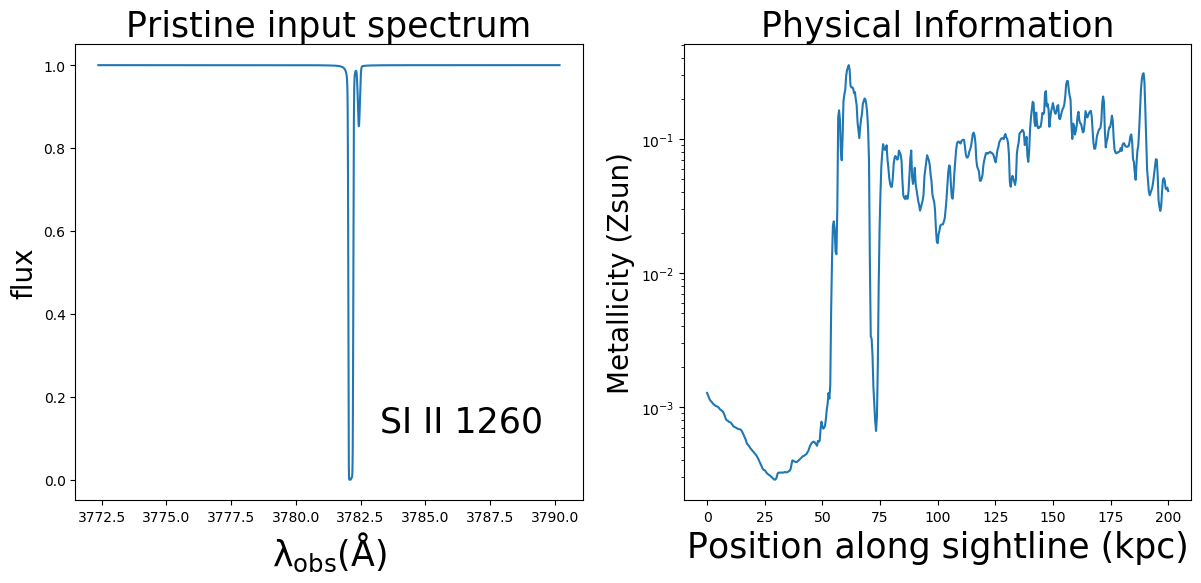

In [105]:
#plot pristine spectrum as well as a vector of intrinsic simulation data

#access pristine spectrum
this_hdu=hdulist[interesting_los[1]['extName']]
pristine_data=this_hdu.data

#access corresponding physical information (see headers for more information)
phys_hdu=hdulist['Physical']
phys_data=phys_hdu.data

fig, (ax1, ax2) = pyplot.subplots(1,2, figsize=(12, 6),dpi=100)
pyplot.subplots_adjust(hspace=0.2,wspace=0.2,top=0.88,bottom=0.12,left=0.06,right=0.99)
ax1.plot(pristine_data['disp_obs'],pristine_data['flux_obs'])

ax1.set_xlabel(r'$\lambda_{\rm obs} (\AA)$',size=25)
ax1.set_ylabel('flux',size=20)
ax1.annotate(this_hdu.header['EXTNAME'],(0.6,0.15),xycoords='axes fraction',size=25)
#ax1.annotate(r'$z_{\rm obs}$'+'={:4.2f}'.format(fo[3].header['OBS_Z']),(0.6,0.08),xycoords='axes fraction',size=25)
ax1.set_title('Pristine input spectrum',size=25)

ax2.semilogy(phys_data['los_position'],phys_data['metallicity'])
ax2.set_xlabel('Position along sightline (kpc)',size=25)
ax2.set_ylabel('Metallicity (Zsun)',size=20)

ax2.set_title('Physical Information',size=25)
fig.savefig(os.path.join(save_location,'asdi1.png'),dpi=300)

### Data Simulation

We can use this information to call the MAST service which applies instrument signatures to pristine data. This API works on one line at a time, and does the simulation server-side to be closer to the data and therefore faster than running locally. The service returns a FITS file, which we can inspect and open.

Pull out the first of our filtered rows, and call the service:

In [84]:
example_row = interesting_los[0]

example_line_name = example_row['lineName']
example_ext_num = example_row['extNum']
example_path = example_row['publicPath']

STIS_sim_filename = os.path.basename(example_path).replace('pristine', 'stis')
print(STIS_sim_filename)

hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0020-axz-dx058.9-dy028.0_v1_stis-los.fits


In [85]:
inst_sim_url = "https://masttest.stsci.edu/asdi/api/v0.1/addsignature"
PARAMS = {'instrument':'STIS', 
          'line_name': example_line_name, 
          'ext_num': example_ext_num, 
          'public_path': example_path,
          'snratioresel': 25,
          'override_observed_wavelength': 1500.0} 
r = requests.get(url = inst_sim_url, params = PARAMS, allow_redirects = True) 

stis_file_path=os.path.join(save_location,STIS_sim_filename)

if r.status_code != 200: #show what went wrong
    #print(r.headers)
    print(r.text)
else:
    open(stis_file_path, 'wb').write(r.content)

In [88]:
fo=fits.open(stis_file_path)
fo.info()
print(fo['SyntheticData'].data.columns)

Filename: ASDI_Sims/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0020-axz-dx058.9-dy028.0_v1_stis-los.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   ()      
  1                1 BinTableHDU     14   638R x 2C   [50A, 50A]   
  2  O VI 1032     1 BinTableHDU     29   3088R x 5C   [E, E, E, E, E]   
  3  SyntheticData    1 BinTableHDU     27   1174R x 4C   [D, D, D, D]   
ColDefs(
    name = 'lam_stis'; format = 'D'
    name = 'flux_stis'; format = 'D'
    name = 'noise'; format = 'D'
    name = 'flux_obs'; format = 'D'
)


***
### Comparing Pristine and Instrument-Specific Data

Files in this public storage can be accessed via http, so we can download them using Python requests and compare:

In [9]:
source_file = 'http://archive.stsci.edu'+example_row['publicPath']
print(source_file)

r = requests.get(source_file, allow_redirects=True)
open(os.path.join(save_location,os.path.basename(source_file)), 'wb').write(r.content)
print('File downloaded: {} bytes'.format(r.headers['Content-length']))

http://archive.stsci.edu/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0020/axz/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0020-axz-dx058.9-dy028.0_v1_pristine-los.fits
File downloaded: 455040 bytes


Now, display simulated data and compare to pristine input data.

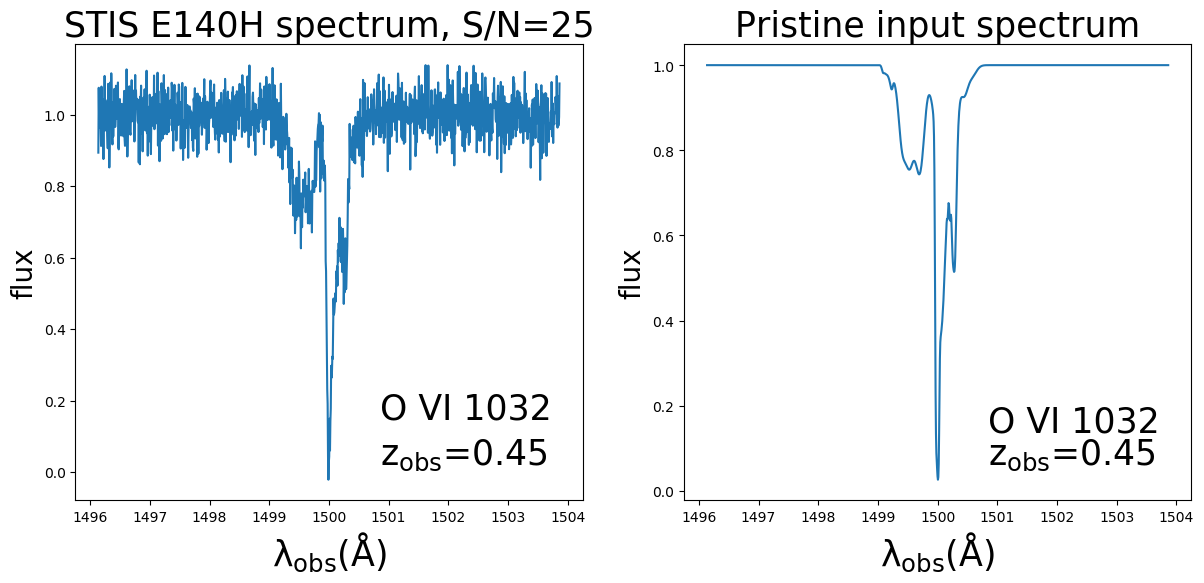

In [106]:
fig2, (ax1, ax2) = pyplot.subplots(1,2, figsize=(12, 6),dpi=100)
pyplot.subplots_adjust(hspace=0.2,wspace=0.2,top=0.88,bottom=0.12,left=0.06,right=0.99)

#plot STIS simulated data
simdata=fo['SyntheticData'].data
ax1.plot(simdata['lam_stis'],simdata['flux_stis'])

#plot original pristine spectrum with same x axis
ax2.plot(simdata['lam_stis'],simdata['flux_obs'])

ax1.set_title('STIS E140H spectrum, S/N=25',size=25)
ax1.set_xlabel(r'$\lambda_{\rm obs} (\AA)$',size=25)
ax1.set_ylabel('flux',size=20)
ax1.annotate(fo['SyntheticData'].header['LINE'],(0.6,0.18),xycoords='axes fraction',size=25)
ax1.annotate(r'$z_{\rm obs}$'+'={:4.2f}'.format(fo[3].header['OBS_Z']),(0.6,0.08),xycoords='axes fraction',size=25)
ax2.set_title('Pristine input spectrum',size=25)
ax2.set_xlabel(r'$\lambda_{\rm obs} (\AA)$',size=25)
ax2.set_ylabel('flux',size=20)
ax2.annotate(fo['SyntheticData'].header['LINE'],(0.6,0.15),xycoords='axes fraction',size=25)
ax2.annotate(r'$z_{\rm obs}$'+'={:4.2f}'.format(fo[3].header['OBS_Z']),(0.6,0.08),xycoords='axes fraction',size=25)

fig2.savefig(os.path.join(save_location,'asdi2.png'),dpi=300)

In [95]:
#define a helper function for looping over parameters
def run_stis_datasim(line_name,ext_num,path,snratioresel=25,override=False,save_location='.'):

    sn_string='-sn{:d}'.format(snratioresel)
    
    STIS_sim_filename = os.path.basename(example_path).replace('pristine', 'stis'+sn_string)
    
    stis_file_path=os.path.join(save_location,STIS_sim_filename)
    
    inst_sim_url = "https://masttest.stsci.edu/asdi/api/v0.1/addsignature"
    PARAMS = {'instrument':'STIS', 
              'line_name': line_name, 
              'ext_num': ext_num, 
              'public_path': path,
              'snratioresel': snratioresel,
              'override_observed_wavelength': override}
    
    if os.path.lexists(stis_file_path):
        print('simulated file exists, skipping service call.')
        return stis_file_path
    
    r = requests.get(url = inst_sim_url, params = PARAMS, allow_redirects = True) 

    if r.status_code != 200: #show what went wrong
        #print(r.headers)
        print(r.text)
    else:
        open(stis_file_path, 'wb').write(r.content)

    return stis_file_path

simulated file exists, skipping service call.
ASDI_Sims/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0020-axz-dx058.9-dy028.0_v1_stis-sn5-los.fits
simulated file exists, skipping service call.
ASDI_Sims/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0020-axz-dx058.9-dy028.0_v1_stis-sn20-los.fits
simulated file exists, skipping service call.
ASDI_Sims/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0020-axz-dx058.9-dy028.0_v1_stis-sn100-los.fits


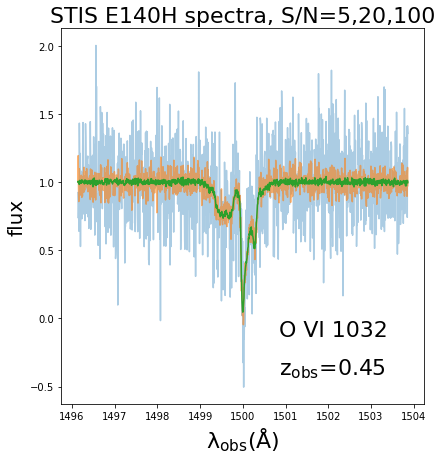

In [104]:
# Simulate STIS data several Signal-to-Noise ratios
sn_list=[5,20,100]

fig3,ax1 = pyplot.subplots(1,1, figsize=(6, 6),dpi=72)
pyplot.subplots_adjust(hspace=0.2,wspace=0.2,top=0.99,bottom=0.12,left=0.15,right=0.99)

#recall that the "example_" parameters were for our selected LOS above.
for sn in sn_list:
    filepath=run_stis_datasim(example_line_name,example_ext_num,example_path,
                              snratioresel=sn,
                              override=1500.0,
                              save_location=save_location)
    print(filepath)
    #open each file successively and overplot
    this_fo=fits.open(filepath)
    this_simdata=this_fo['SyntheticData'].data
    ax1.plot(this_simdata['lam_stis'],this_simdata['flux_stis'],alpha=(sn/100.0)**0.33)

ax1.set_title('STIS E140H spectra, S/N=5,20,100',size=22)
ax1.set_xlabel(r'$\lambda_{\rm obs} (\AA)$',size=22)
ax1.set_ylabel('flux',size=20)
ax1.annotate(fo['SyntheticData'].header['LINE'],(0.6,0.18),xycoords='axes fraction',size=22)
ax1.annotate(r'$z_{\rm obs}$'+'={:4.2f}'.format(this_fo[3].header['OBS_Z']),(0.6,0.08),xycoords='axes fraction',size=22)

fig3.savefig(os.path.join(save_location,'asdi3.png'),dpi=300)

### Contributors
* Theresa Dower
* Gregory Snyder
* Molly Peeples